In [ ]:
!gdown --id 1OkpX_Md-lFwCo5TB_cq0Qxoe4oEB8eKG

!wget https://saliency.tuebingen.ai/data/coco_search18_TP.zip 
!unzip -q coco_search18_TP.zip -d './'

Downloading...
From: https://drive.google.com/uc?id=1OkpX_Md-lFwCo5TB_cq0Qxoe4oEB8eKG
To: /content/bbox_annos.npy
100% 127k/127k [00:00<00:00, 49.1MB/s]
--2021-06-14 21:24:53--  https://saliency.tuebingen.ai/data/coco_search18_TP.zip
Resolving saliency.tuebingen.ai (saliency.tuebingen.ai)... 46.101.242.241, 2a03:b0c0:3:d0::5503:c001
Connecting to saliency.tuebingen.ai (saliency.tuebingen.ai)|46.101.242.241|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2932992 (2.8M) [application/zip]
Saving to: ‘coco_search18_TP.zip’

coco_search18_TP.zi 100%[===================>]   2.80M  3.58MB/s    in 0.8s    

2021-06-14 21:24:55 (3.58 MB/s) - ‘coco_search18_TP.zip’ saved [2932992/2932992]



In [ ]:
import cv2
import numpy as np
import os
from tqdm import tqdm
from shutil import copyfile
import seaborn as sns
import pandas as pd

In [ ]:
def data_analysis(train_task_img_pair,
                         trajs,
                         im_h,
                         im_w,
                         bbox,
                         truncate_num=-1,
                         need_label=True):
  
    min_fix_x=100000
    max_fix_x=-100000
    min_fix_y=100000
    max_fix_y=-100000

    for traj in trajs:
      for i in range(len(traj['X'])):
        if traj['X'][i]<0 or traj['Y'][i]<0 or traj['X'][i]>1680 or traj['Y'][i]>1050:
          continue

        if traj['X'][i]<min_fix_x :
          min_fix_x = traj['X'][i]

        if traj['X'][i]>max_fix_x :
          max_fix_x = traj['X'][i]

        if traj['Y'][i]<min_fix_y :
          min_fix_y = traj['Y'][i]
 
        if traj['Y'][i]>max_fix_y :
          max_fix_y = traj['Y'][i]

    label_dict = {'bottle':0 , 'bowl':1, 'car':2, 'chair':3, 'clock':4, 'cup':5, 
                  'fork':6, 'keyboard':7, 'knife':8, 'laptop':9, 'microwave':10,
                  'mouse':11, 'oven':12, 'potted plant':13, 'sink':14, 
                  'stop sign':15, 'toilet':16, 'tv':17}
    
    response_t = np.zeros((2250,18))
    fixation_num = np.zeros((2250,18))
    non_t_fixation_duration = np.zeros((100000,18))
    t_fixation_duration = np.zeros((100000,18))
    category_error =  np.zeros(18)
    subject_RT = np.zeros((3000,10))
    subject_fix_num = np.zeros((3000,10))

    subject_error = np.zeros(10)
    non_t_subject_fix_duration = np.zeros((100000,10))
    t_subject_fix_duration = np.zeros((100000,10))
    counter = np.zeros(18)
    counter_subj = np.zeros(10)

    c=0

    targets_area = []
    targets_area_2 = []
    response_times = []
    targets_eccentricity = []
    targets_eccentricity_2 = []
    fixation_numbers = []
    fixation_dur = []
    target_fixation_dur = []
    targ_num_fix = []

    for traj in trajs:   
           
      counter[label_dict[traj['task']]]+=1
      counter_subj[int(traj['subject'])-1]+=1
      response_t[ int(counter[label_dict[traj['task']]])-1 , int(label_dict[traj['task']]) ] = traj['RT']
      fixation_num [ int(counter[label_dict[traj['task']]])-1 , int(label_dict[traj['task']]) ] = traj['length'] -1 #remove initial fix

      subject_RT [int(counter_subj[int(traj['subject'])-1])-1 , int(traj['subject'])-1] = traj['RT']
      subject_fix_num [int(counter_subj[int(traj['subject'])-1])-1 , int(traj['subject'])-1] = traj['length'] -1  #remove initial fix
      
      if traj["correct"]== 0:
        #print('subj',traj['subject'])
        subject_error [int(traj['subject'])-1] +=1
        category_error[int(label_dict[traj['task']])]+=1

      task_img = traj['task'] + '_' + traj['name']

      x1 = bbox[task_img][0]
      y1 = bbox[task_img][1]
      w_image = bbox[task_img][2]
      h_image = bbox[task_img][3]
      
      eucl_dist = np.sqrt(np.power(abs(x1+(w_image/2) - (im_w / 2)),2) + np.power(abs(y1+(h_image/2) - (im_h / 2)),2))
      

      # first fixations are fixed at the screen center
      traj['X'][0], traj['Y'][0] = im_w / 2, im_h / 2
      traj_len = len(traj['X'])
      
      d=0
      targ_fix_d =0
      t = 0 
      for i in range(1, traj_len): # not considering initial fixation and target fixation

          
          if traj['X'][i]<0 or traj['Y'][i]<0 or traj['X'][i]>1680 or traj['Y'][i]>1050:
              continue
          
          fix = (((traj['X'][i]-min_fix_x)/max_fix_x)*(512), ((traj['Y'][i]-min_fix_y)/max_fix_y)*(320))
          
          if (x1<=fix[0]<=x1+w_image and y1<=fix[1]<=y1+h_image):
              
              t += 1
              targ_fix_d += traj['T'][i]
              t_fixation_duration [ int(counter[label_dict[traj['task']]])-1+i , int(label_dict[traj['task']])] = traj['T'][i]
              t_subject_fix_duration [int(counter_subj[int(traj['subject'])-1])-1+i , int(traj['subject'])-1] = traj['T'][i]
              
              continue

          non_t_fixation_duration [ int(counter[label_dict[traj['task']]])-1+i , int(label_dict[traj['task']])] = traj['T'][i]
          non_t_subject_fix_duration [int(counter_subj[int(traj['subject'])-1])-1+i , int(traj['subject'])-1] = traj['T'][i]
          d +=traj['T'][i]

      if len(traj['X'])-1 != 0:
        
        fixation_dur.append(d/(len(traj['X'])-1)) 
        targets_eccentricity.append(eucl_dist)
        targets_area.append(w_image*h_image)
        response_times.append(traj['RT']) 
        fixation_numbers.append(traj['length']) 
        if t !=0:
          target_fixation_dur.append(targ_fix_d/t)
          targets_area_2.append(w_image*h_image)
          targets_eccentricity_2.append(eucl_dist)
          targ_num_fix.append(t)
    
    return  (fixation_num , response_t, non_t_fixation_duration, t_fixation_duration, subject_RT, 
    subject_fix_num, non_t_subject_fix_duration, t_subject_fix_duration, subject_error,category_error,
    targets_area, response_times, targets_eccentricity, fixation_numbers,
    fixation_dur, target_fixation_dur, targets_area_2, targets_eccentricity_2, targ_num_fix) 

In [ ]:
import numpy as np


def process_data(trajs_train,
                 trajs_valid,
                 target_annos,
                 is_testing=False):
    im_w= 512
    im_h= 320
    max_traj_length = 6

    target_init_fixs = {}
    cat_names = list(np.unique([x['task'] for x in trajs_train]))
    catIds = dict(zip(cat_names, list(range(len(cat_names)))))
    trajs = trajs_train + trajs_valid
    # training fixation data
    task_img_pair = np.unique(
        [traj['task'] + '_' + traj['name'] for traj in trajs])
    
    (fix_num, re_time, n_fix_duration, t_fix_duration, subj_RT,  subj_fix_num, subj_fix_dur, subj_er,
    cat_er, tar_area, res_times, tar_eccent, fixation_numbers, n_fixation_dur, t_fixation_dur,
    tar_fix_dur, tar_area_2, tar_eccen_2, targ_num_fix) = data_analysis(
        task_img_pair,
        trajs,  
        im_h,
        im_w,
        target_annos,
        truncate_num=max_traj_length)

    return (fix_num, re_time, n_fix_duration, t_fix_duration, subj_RT, subj_fix_num,  subj_fix_dur,
    subj_er, cat_er, tar_area, res_times, tar_eccent, fixation_numbers,
    n_fixation_dur, t_fixation_dur, tar_fix_dur, tar_area_2, tar_eccen_2, targ_num_fix)

{'fork_000000537944.jpg': [56, 229, 33, 49], 'knife_000000233539.jpg': [372, 193, 114, 92], 'tv_000000192651.jpg': [51, 138, 60, 54], 'laptop_000000335308.jpg': [16, 210, 52, 39], 'sink_000000164725.jpg': [158, 219, 159, 94], 'fork_000000061672.jpg': [383, 101, 51, 141], 'laptop_000000204979.jpg': [48, 98, 130, 101], 'mouse_000000539056.jpg': [386, 206, 41, 44], 'fork_000000323370.jpg': [399, 55, 65, 184], 'tv_000000203160.jpg': [98, 57, 71, 71], 'fork_000000256278.jpg': [16, 51, 48, 123], 'keyboard_000000491851.jpg': [151, 201, 157, 64], 'fork_000000169803.jpg': [346, 186, 121, 59], 'fork_000000483837.jpg': [406, 147, 71, 171], 'stop sign_000000249363.jpg': [425, 136, 44, 44], 'potted plant_000000452524.jpg': [398, 55, 62, 147], 'tv_000000159240.jpg': [321, 166, 53, 53], 'cup_000000370652.jpg': [132, 1, 88, 95], 'microwave_000000220096.jpg': [186, 77, 73, 37], 'laptop_000000457705.jpg': [54, 185, 89, 53], 'potted plant_000000171316.jpg': [210, 258, 39, 41], 'sink_000000424959.jpg': [4

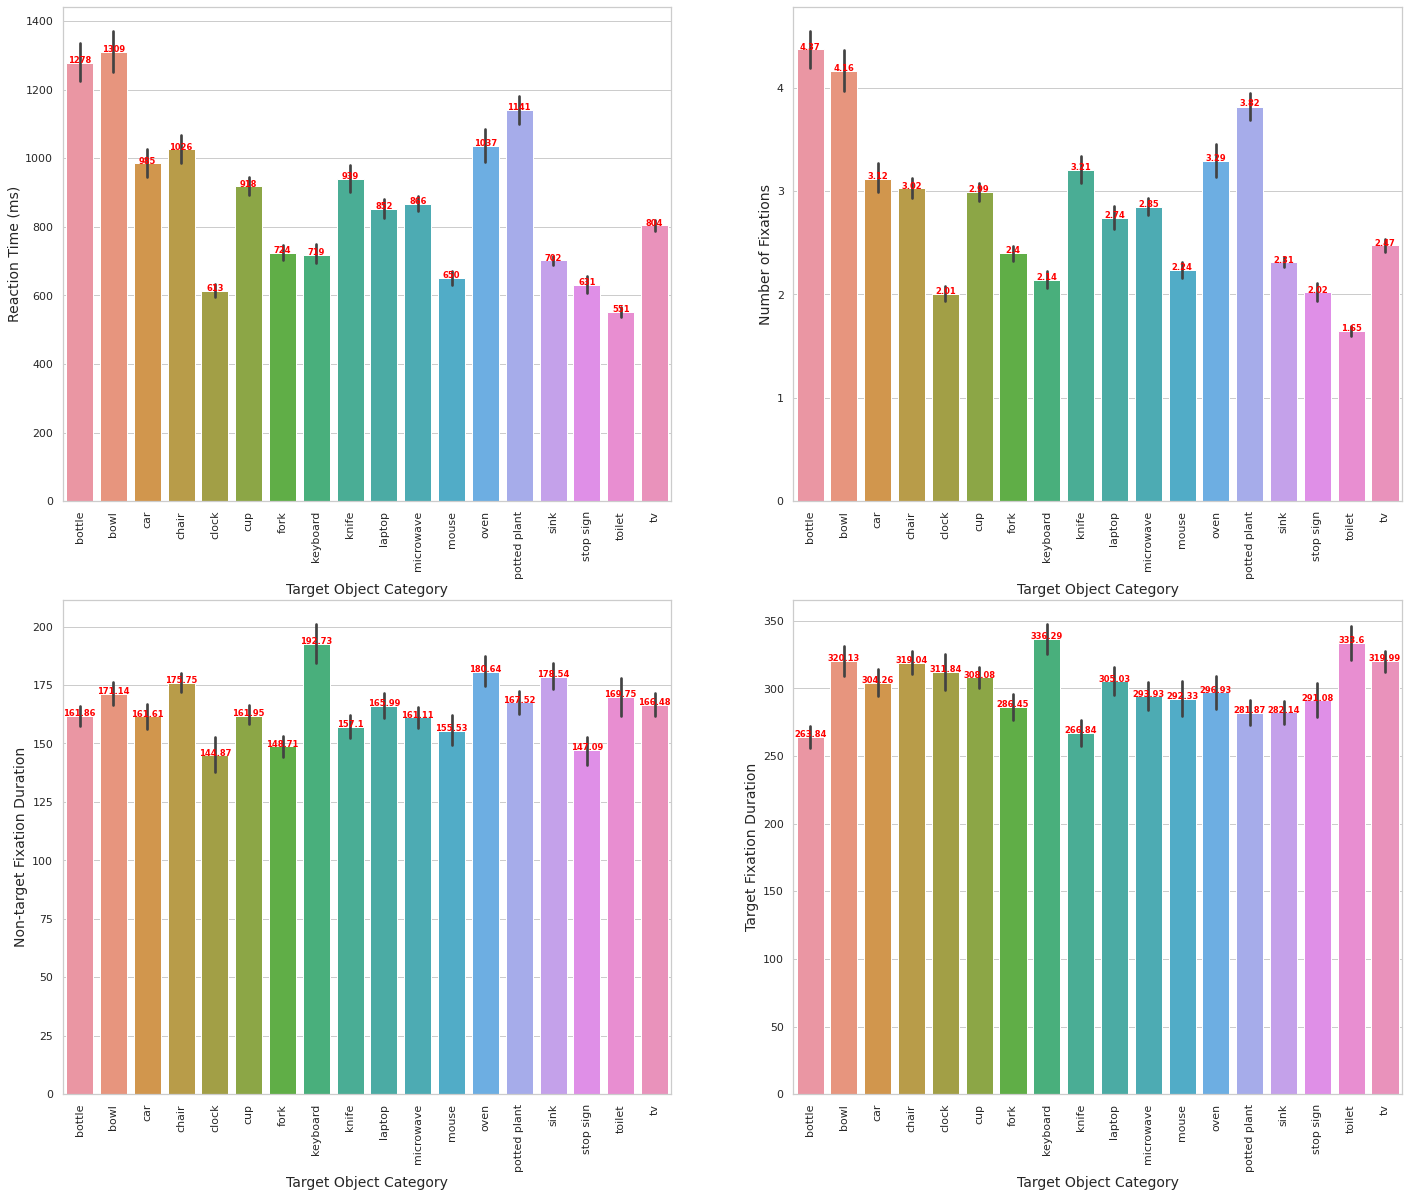

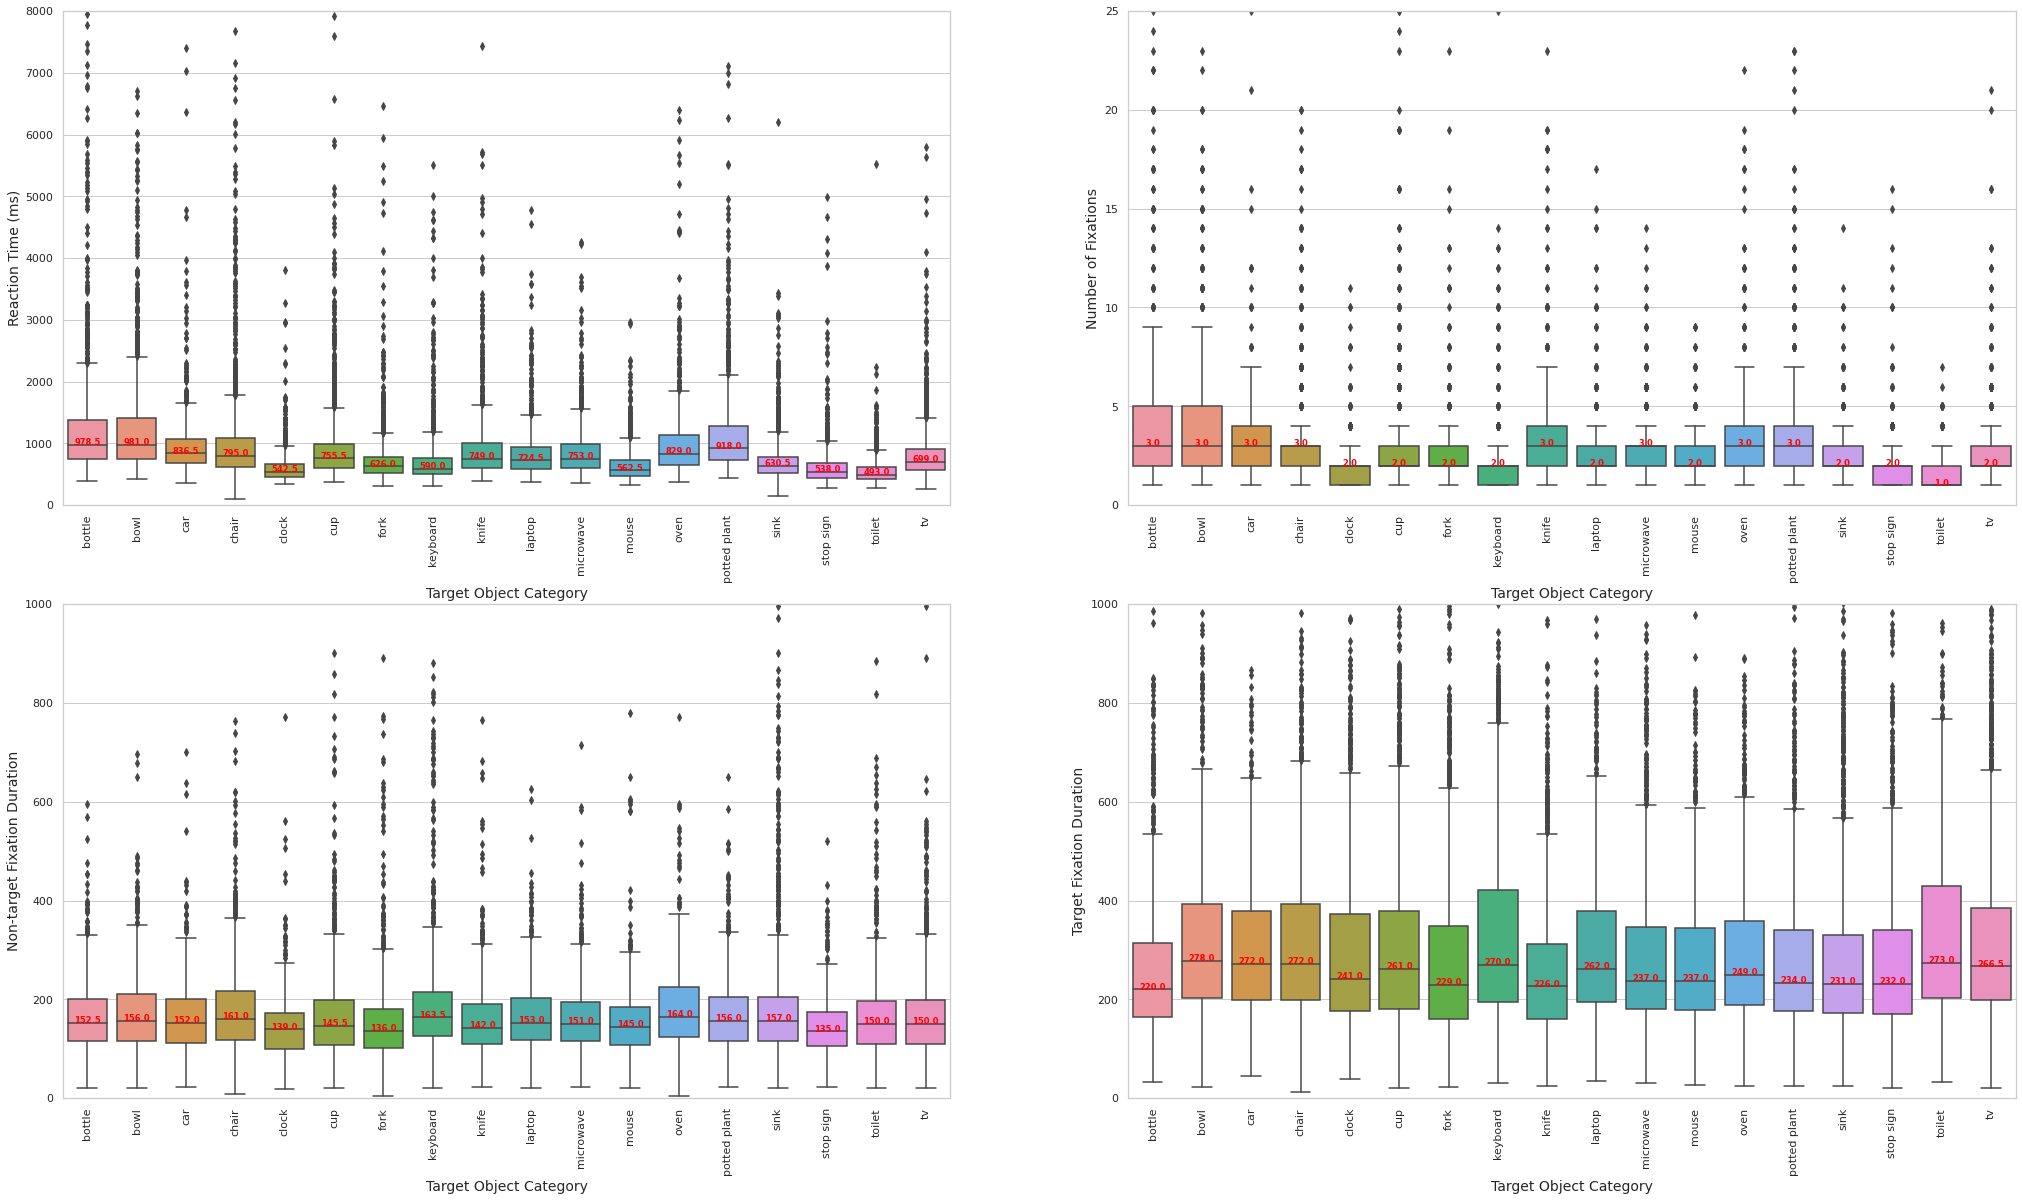

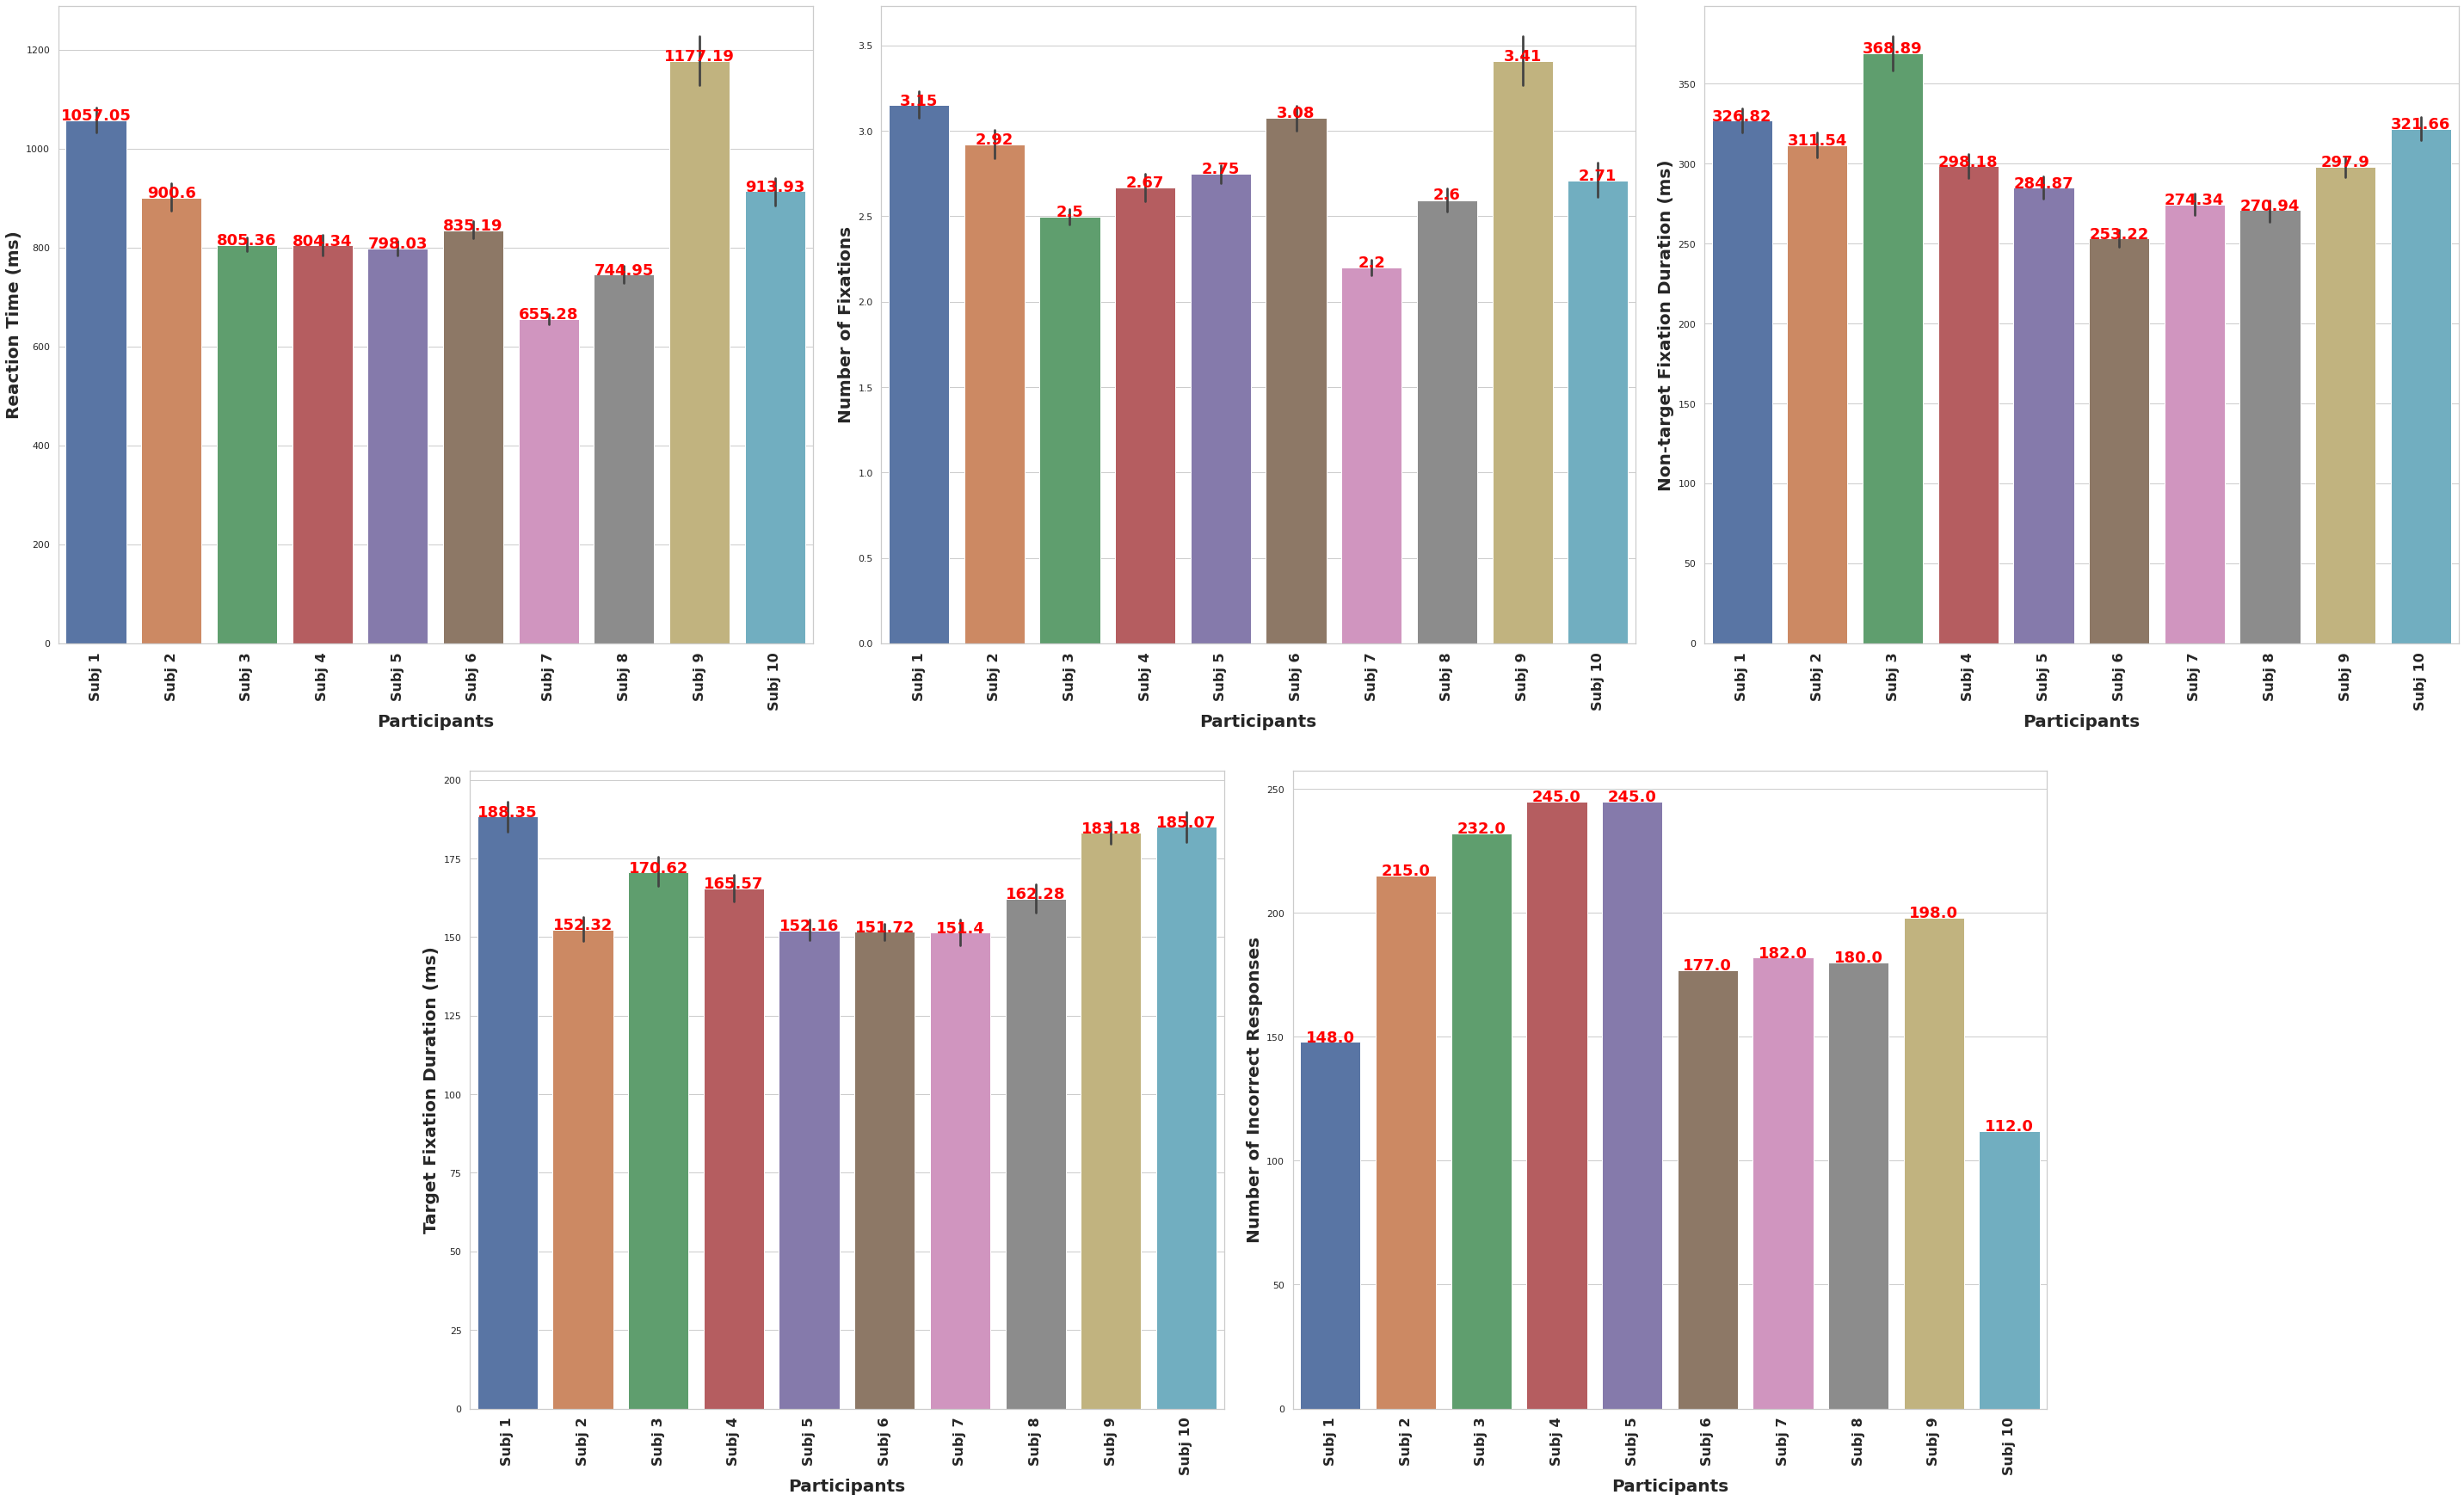

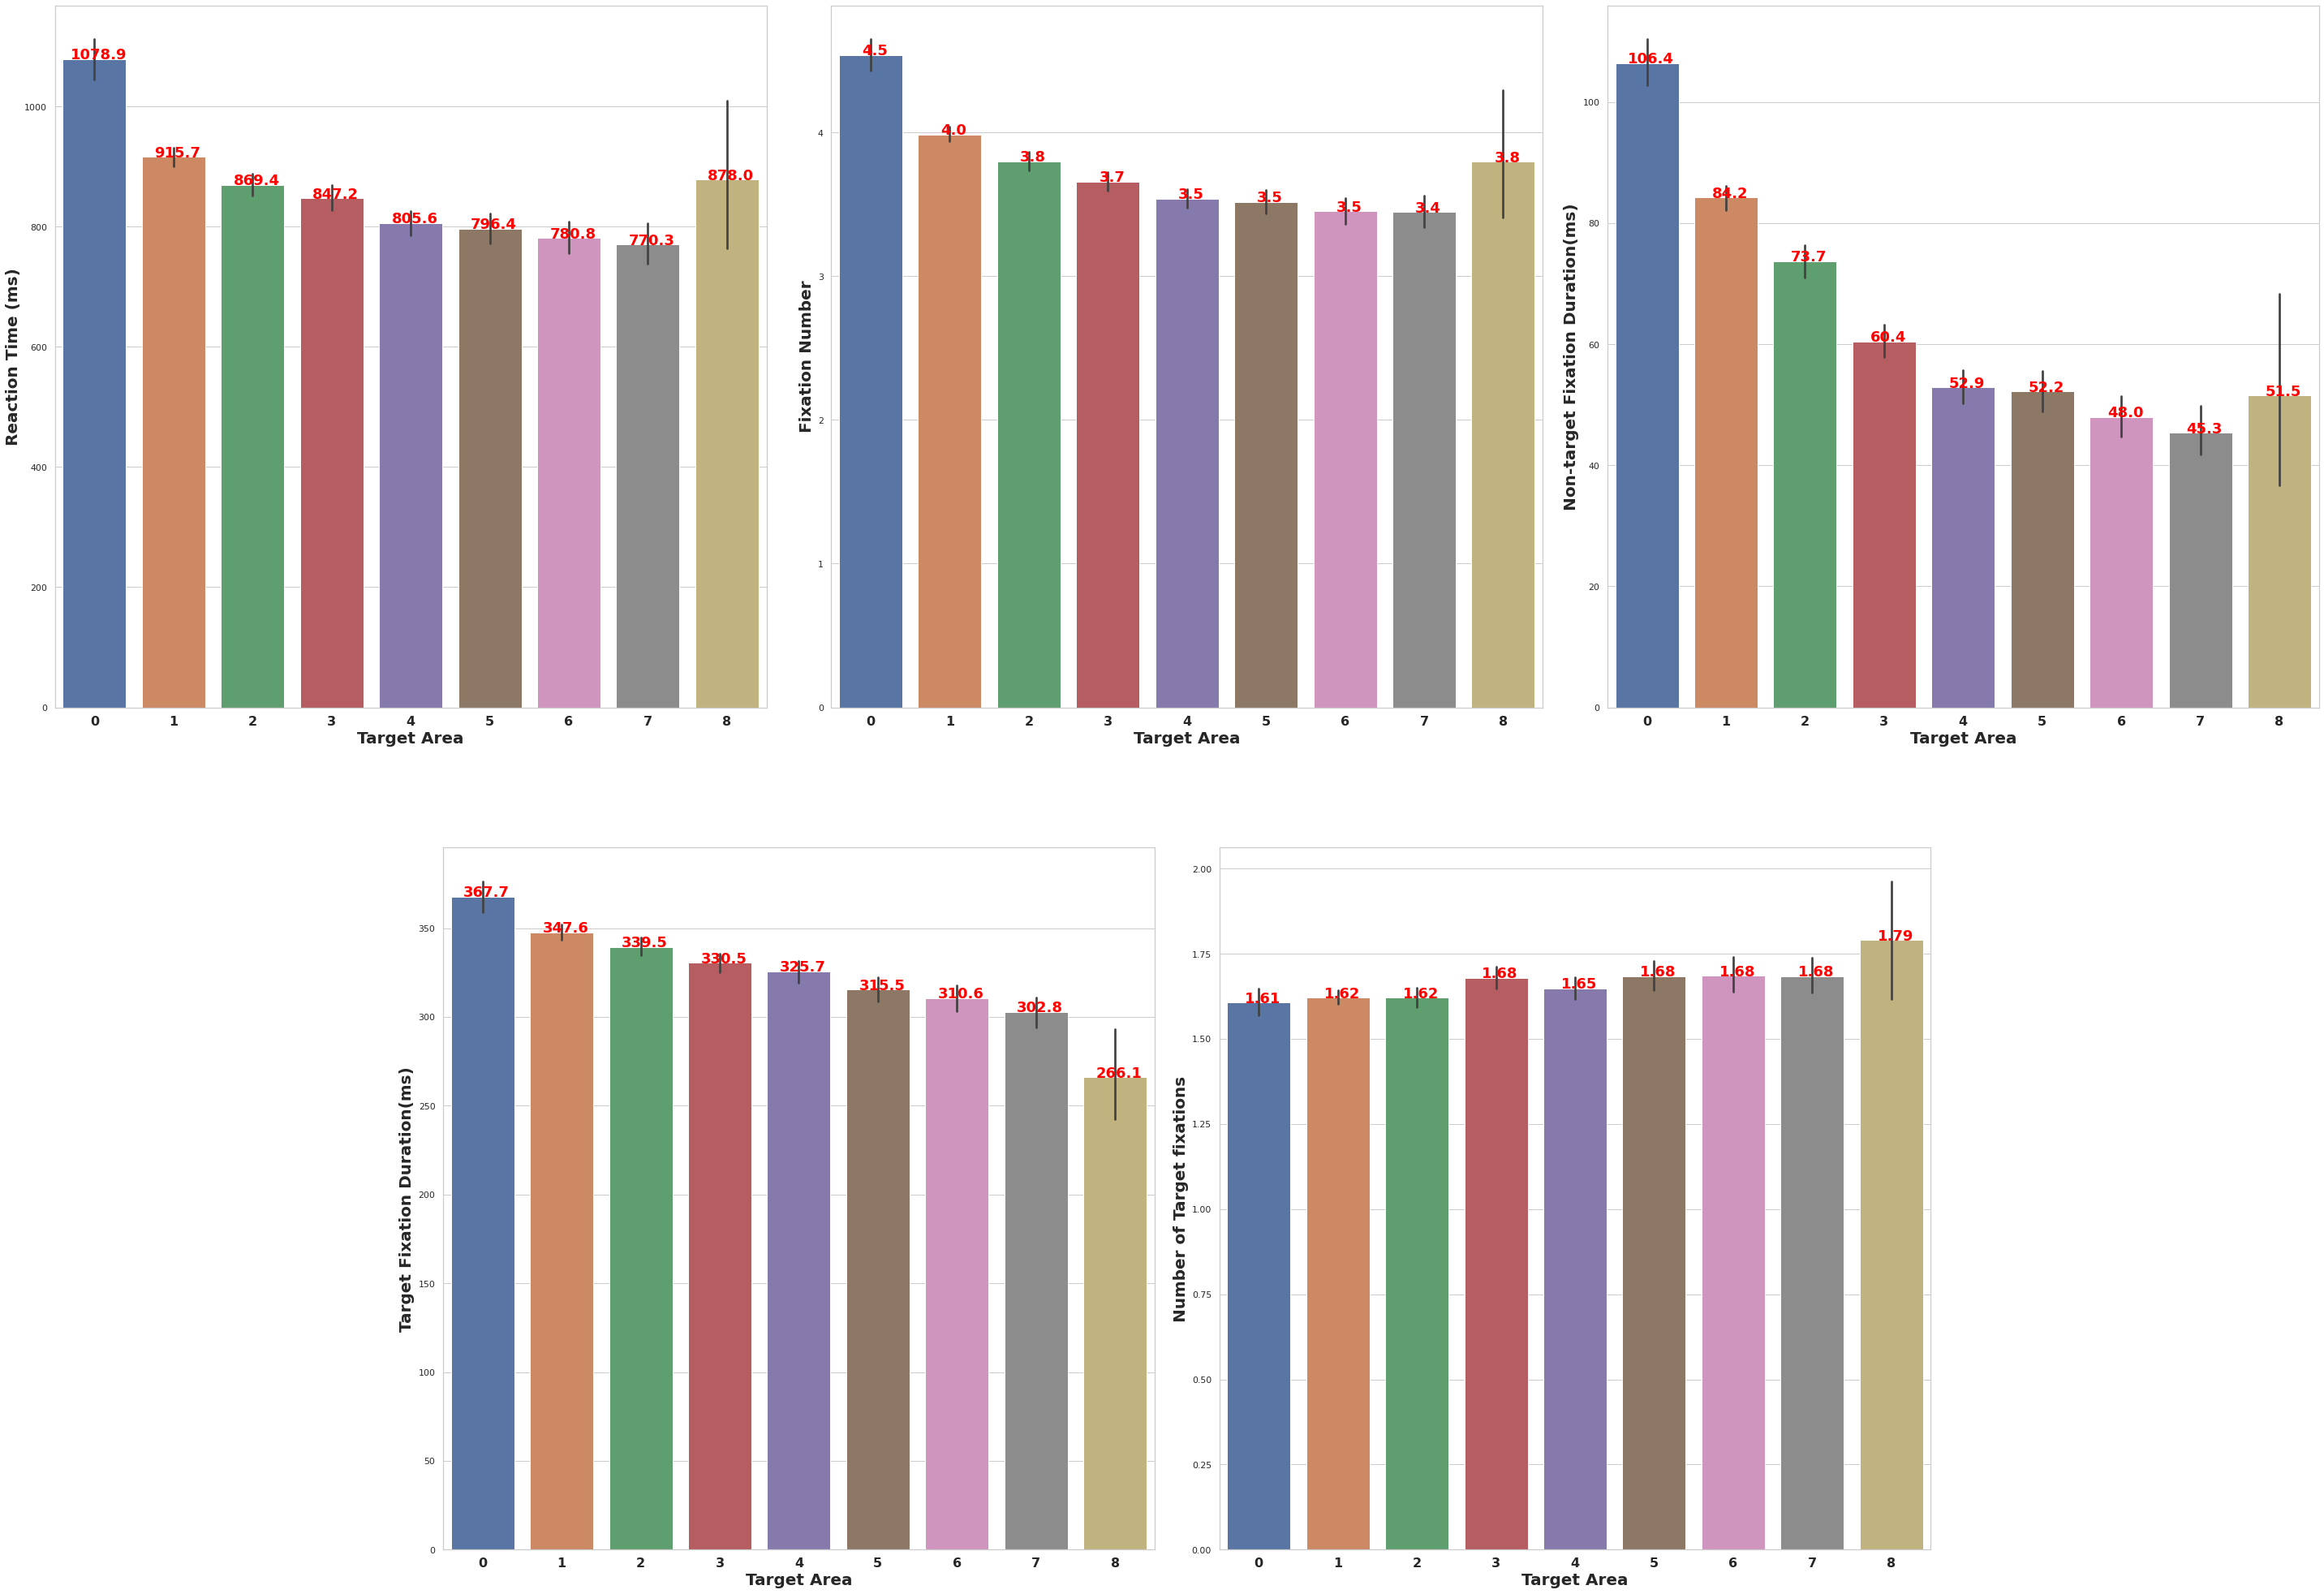

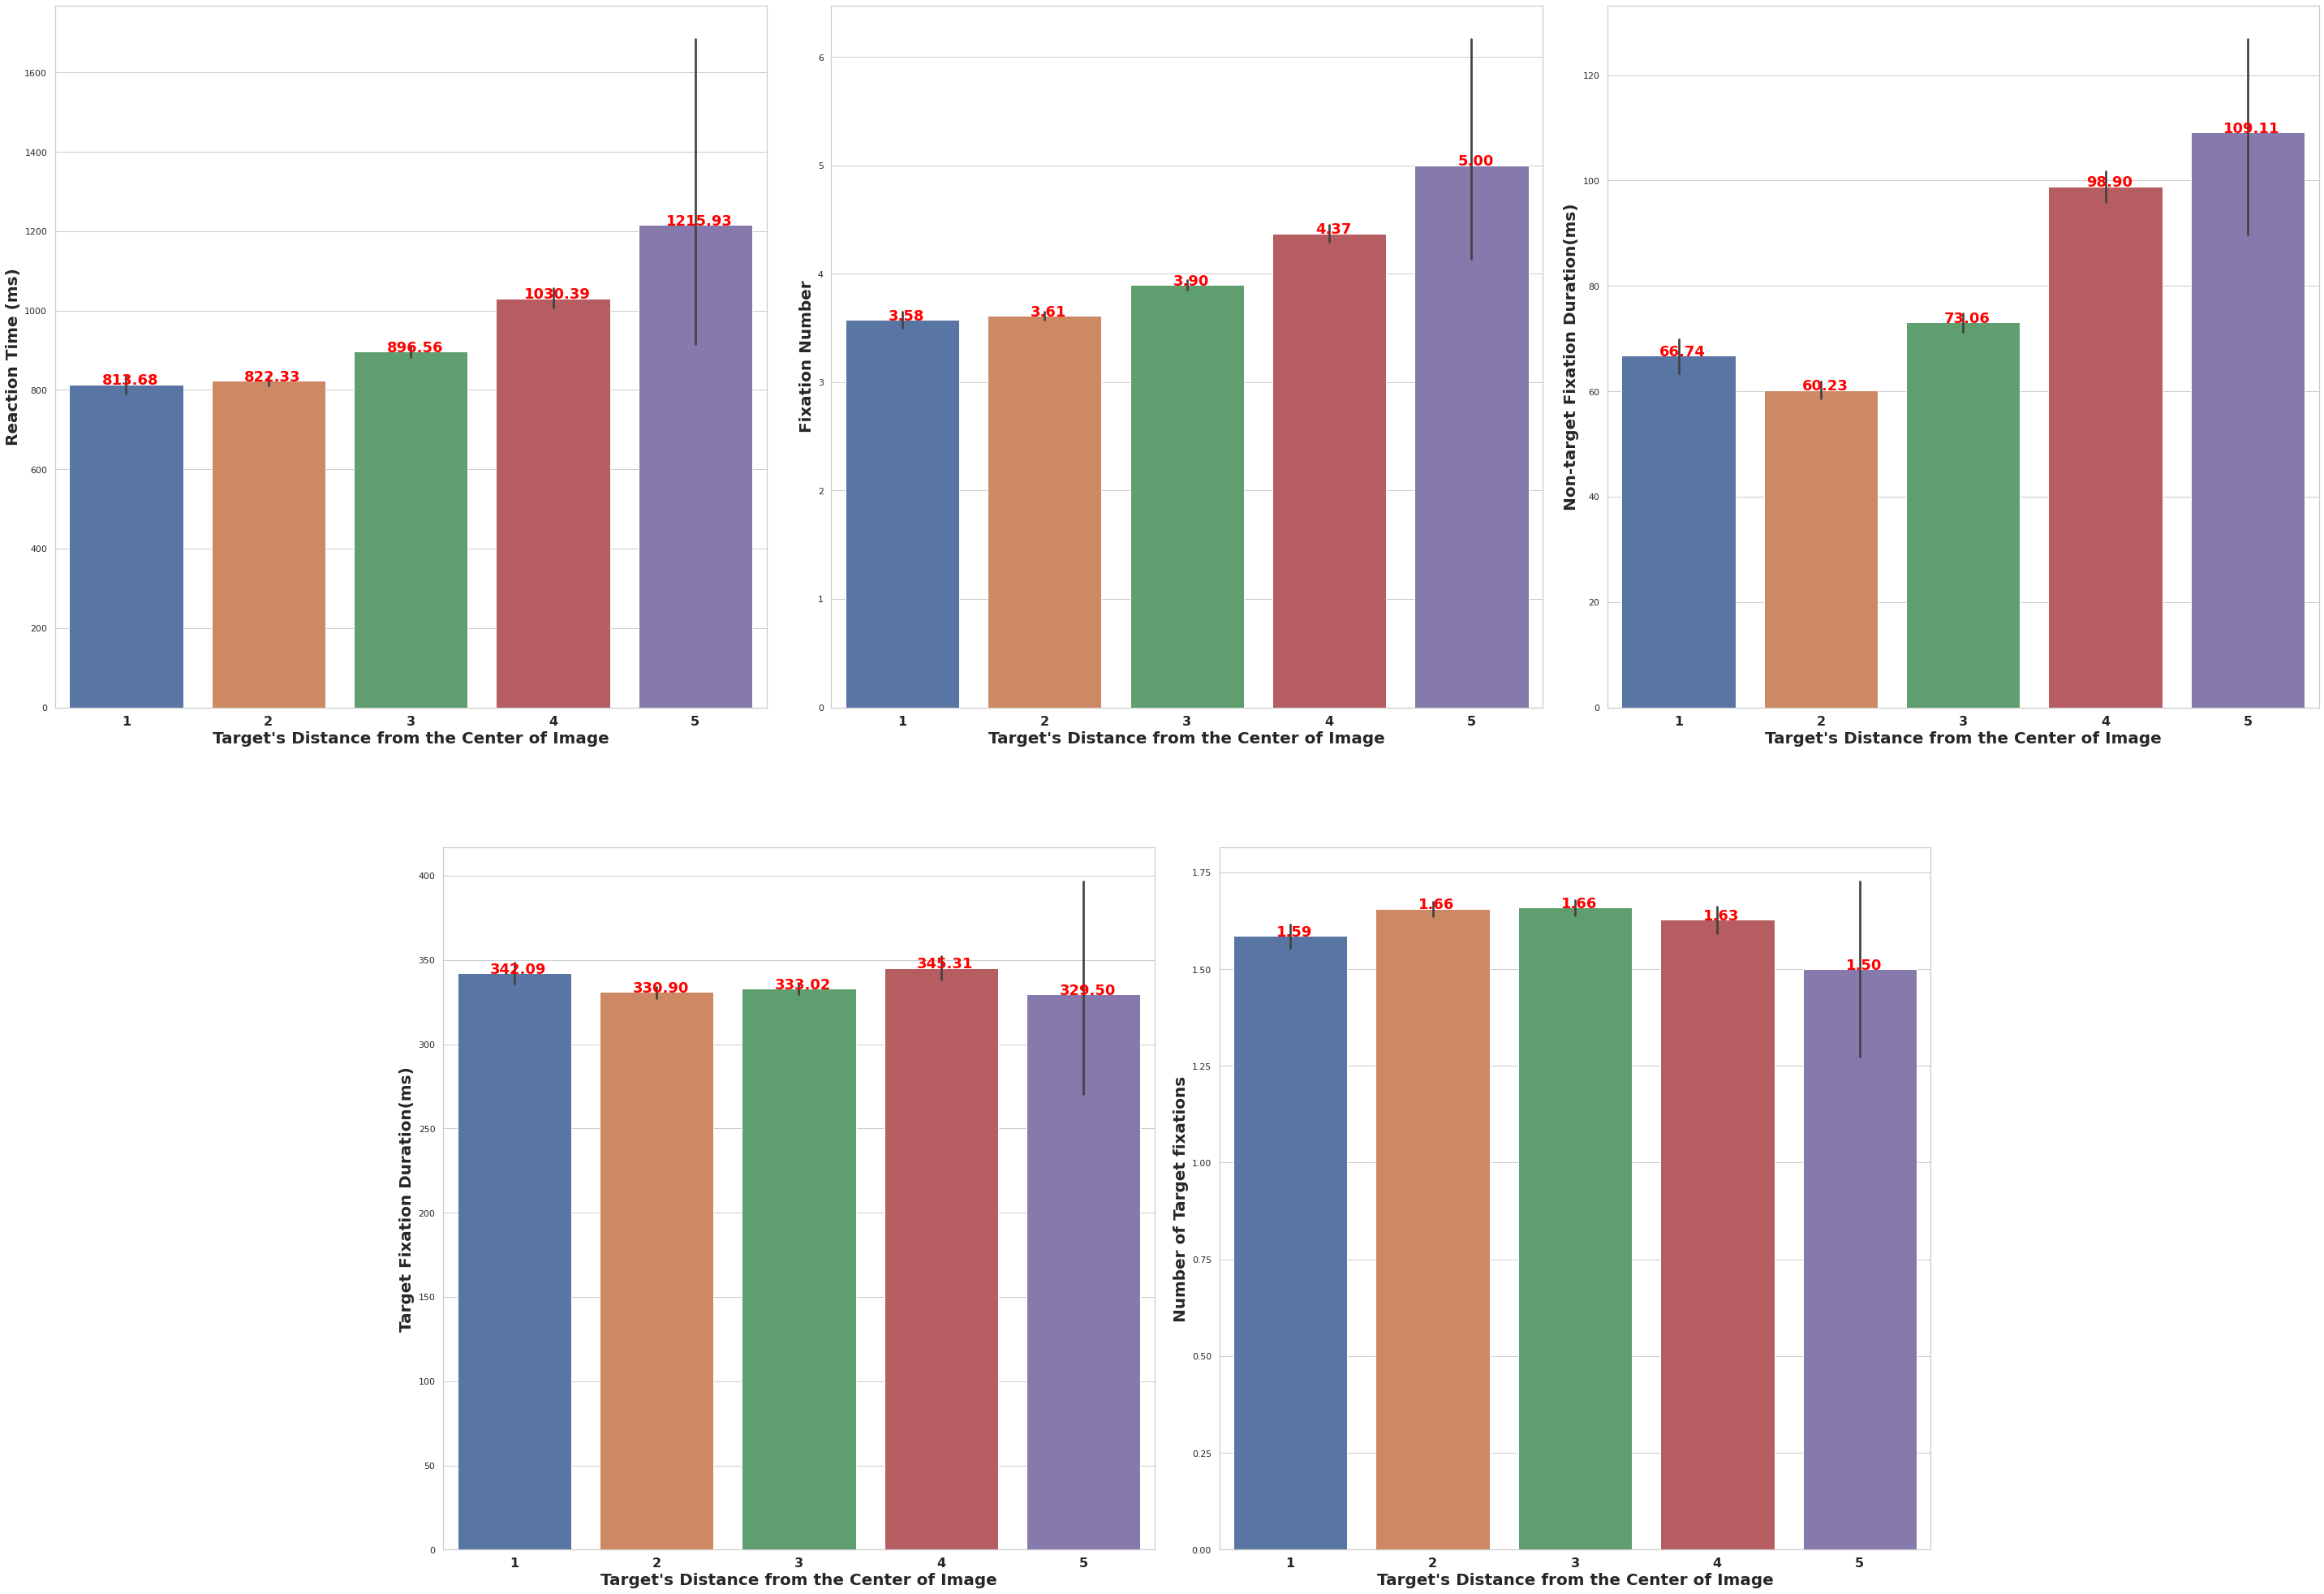

In [ ]:
import torch
import numpy as np
import json
from os.path import join
import numpy as np
from itertools import groupby
import random
import matplotlib.pylab as plt
import matplotlib.patheffects as path_effects

torch.manual_seed(42619)
np.random.seed(42619)

if __name__ == '__main__':


    dataset_root = './'
    if torch.cuda.is_available():
      device = torch.device("cuda")
    else:
      device = torch.device("cpu")

    # bounding box of the target object (for search efficiency evaluation)
    bbox_annos = np.load(join(dataset_root, 'bbox_annos.npy'),
                         allow_pickle=True).item()
    print( bbox_annos)

    # load ground-truth human scanpaths

    with open(join(dataset_root,
                   'coco_search18_fixations_TP_train_split1.json')) as json_file:
        human_scanpaths_train = json.load(json_file)

    with open(join(dataset_root,
                   'coco_search18_fixations_TP_validation_split1.json')) as json_file:
        human_scanpaths_valid = json.load(json_file)
  
    # exclude incorrect scanpaths
    '''human_scanpaths_train = list(
        filter(lambda x: x['correct'] == 1, human_scanpaths_train))
    human_scanpaths_valid = list(
        filter(lambda x: x['correct'] == 1, human_scanpaths_valid))'''
    
    # process fixation data
    (fix_num, reaction_time,  n_fix_dur, t_fix_dur, subj_rt,  subj_fix_n, n_subj_fix_dur , t_subj_fix_dur, subj_er, \
    cat_er, tar_area, res_times, tar_eccent, fix_nums, f_dur, tar_fix_dur, \
    tar_area_2, tar_eccen_2, targ_num_fix)  = process_data(human_scanpaths_train, human_scanpaths_valid, bbox_annos)

    col =  ['bottle' , 'bowl',  'car', 'chair', 'clock', 'cup', 
            'fork', 'keyboard', 'knife', 'laptop', 'microwave',
            'mouse', 'oven', 'potted plant', 'sink', 'stop sign', 'toilet', 'tv']

    ##############################################################################

    plt.figure(figsize=(24,20))
    plt.subplot(2,2,1)
    
    RT = pd.DataFrame(reaction_time, columns = col)
    RT.replace(0, np.nan, inplace=True)

    #sns.set_xticklabels(rotation=30)
    sns.set(rc={'figure.figsize':(15,15)})    
    sns.set_theme(style="whitegrid")

    bar_plot = sns.barplot(data = RT)
    means = RT.mean()
    #vertical_offset = RT.median() * 0.05 # offset from median for display

    for xtick in bar_plot.get_xticks():
        bar_plot.text(xtick,round(means[xtick]) , round(means[xtick]), 
                horizontalalignment='center',size='x-small',color='red',weight='semibold')
    plt.ylabel("Reaction Time (ms)", size=14)
    plt.xlabel("Target Object Category", size=14)
    plt.title("", size=18)
    plt.xticks(rotation=90)

    plt.subplot(2,2,2)

    Fix = pd.DataFrame(fix_num, columns = col)
    Fix.replace(0, np.nan, inplace=True)

    bar_fix_plot = sns.barplot(data = Fix)
    mean_fixs = Fix.mean()
    #vertical_offset = RT.median() * 0.05 # offset from median for display

    for xtick in bar_fix_plot.get_xticks():
        bar_fix_plot.text(xtick, round(mean_fixs[xtick] , 2) , round(mean_fixs[xtick] , 2), 
                horizontalalignment='center',size='x-small',color='red',weight='semibold')
        
    plt.ylabel("Number of Fixations", size=14)
    plt.xlabel("Target Object Category", size=14)
    plt.title("", size=18)
    plt.xticks(rotation=90)  


    plt.subplot(2,2,3)

    n_Dur = pd.DataFrame(n_fix_dur, columns = col)
    n_Dur.replace(0, np.nan, inplace=True)

    bar_fix_dur_plot = sns.barplot(data = n_Dur)
    mean_dur_fixs = n_Dur.mean()
    #vertical_offset = RT.median() * 0.05 # offset from median for display

    for xtick in bar_fix_dur_plot.get_xticks():
        bar_fix_dur_plot.text(xtick, round(mean_dur_fixs[xtick] , 2) , round(mean_dur_fixs[xtick] , 2), 
                horizontalalignment='center',size='x-small',color='red',weight='semibold')
        
    plt.ylabel("Non-target Fixation Duration", size=14)
    plt.xlabel("Target Object Category", size=14)
    plt.title("", size=18)
    plt.xticks(rotation=90)


    plt.subplot(2,2,4)

    t_Dur = pd.DataFrame(t_fix_dur, columns = col)
    t_Dur.replace(0, np.nan, inplace=True)

    bar_fix_dur_plot = sns.barplot(data = t_Dur)
    mean_dur_fixs = t_Dur.mean()
    #vertical_offset = RT.median() * 0.05 # offset from median for display

    for xtick in bar_fix_dur_plot.get_xticks():
        bar_fix_dur_plot.text(xtick, round(mean_dur_fixs[xtick] , 2) , round(mean_dur_fixs[xtick] , 2), 
                horizontalalignment='center',size='x-small',color='red',weight='semibold')
        
    plt.ylabel("Target Fixation Duration", size=14)
    plt.xlabel("Target Object Category", size=14)
    plt.title("", size=18)
    plt.xticks(rotation=90)

    plt.show()  
    
    ###############################################################################

    plt.figure(figsize=(35,20))
    plt.subplot(2,2,1)

    box_plot = sns.boxplot(data = RT)
    medians = RT.median()
    #vertical_offset = RT.median() * 0.05 # offset from median for display

    for xtick in box_plot.get_xticks():
        box_plot.text(xtick,medians[xtick] ,medians[xtick], 
                horizontalalignment='center',size='x-small',color='red',weight='semibold')
    
    plt.ylabel("Reaction Time (ms)", size=14)
    plt.xlabel("Target Object Category", size=14)
    plt.title("", size=18)
    plt.ylim(0, 8000)
    plt.xticks(rotation=90)


    plt.subplot(2,2,2)
    box_plot = sns.boxplot(data = Fix)
    medians = Fix.median()
    #vertical_offset = RT.median() * 0.05 # offset from median for display

    for xtick in box_plot.get_xticks():
        box_plot.text(xtick,medians[xtick] ,medians[xtick], 
                horizontalalignment='center',size='x-small',color='red',weight='semibold')
    
    plt.ylabel("Number of Fixations", size=14)
    plt.xlabel("Target Object Category", size=14)
    plt.title("", size=18)
    plt.ylim(0, 25)
    plt.xticks(rotation=90)
    

    plt.subplot(2,2,3)
    box_plot = sns.boxplot(data = n_Dur)
    medians = n_Dur.median()
    #vertical_offset = RT.median() * 0.05 # offset from median for display

    for xtick in box_plot.get_xticks():
        box_plot.text(xtick,medians[xtick] ,medians[xtick], 
                horizontalalignment='center',size='x-small',color='red',weight='semibold')
    
    plt.ylabel("Non-target Fixation Duration", size=14)
    plt.xlabel("Target Object Category", size=14)
    plt.title("", size=18)
    plt.ylim(0, 1000)
    plt.xticks(rotation=90)
    

    plt.subplot(2,2,4)
    box_plot = sns.boxplot(data = t_Dur)
    medians = t_Dur.median()
    #vertical_offset = RT.median() * 0.05 # offset from median for display

    for xtick in box_plot.get_xticks():
        box_plot.text(xtick,medians[xtick] ,medians[xtick], 
                horizontalalignment='center',size='x-small',color='red',weight='semibold')
    
    plt.ylabel("Target Fixation Duration", size=14)
    plt.xlabel("Target Object Category", size=14)
    plt.title("", size=18)
    plt.ylim(0, 1000)
    plt.xticks(rotation=90)    
    
    plt.show()  


    ###############################################################################
    subj_col =  ['Subj 1' , 'Subj 2',  'Subj 3', 'Subj 4', 'Subj 5', 'Subj 6', 'Subj 7', 
            'Subj 8', 'Subj 9', 'Subj 10']


    plt.figure(figsize=(50,30))
    #plt.subplot(1,4,1)
    plt.subplot2grid(shape=(2,6), loc=(0,0), colspan=2)
    subj_RT = pd.DataFrame(subj_rt, columns = subj_col)
    subj_RT.replace(0, np.nan, inplace=True)

    bar_subj_RT_plot = sns.barplot(data = subj_RT)
    mean_subj_RT = subj_RT.mean()
    #vertical_offset = RT.median() * 0.05 # offset from median for display

    for xtick in bar_subj_RT_plot.get_xticks():
        bar_subj_RT_plot.text(xtick, round(mean_subj_RT[xtick] , 2) , round(mean_subj_RT[xtick] , 2), 
                horizontalalignment='center',size=18,color='red',weight='semibold')
        
    plt.ylabel("Reaction Time (ms)", size=20,  weight='semibold')
    plt.xlabel("Participants", size=20,  weight='semibold')
    plt.title("", size=18)
    plt.xticks(rotation=90, size=16,  weight='semibold')
    #plt.show() 

    #plt.subplot(1,4,2)
    plt.subplot2grid((2,6), (0,2), colspan=2)
    subj_fix_n = pd.DataFrame(subj_fix_n, columns = subj_col)
    subj_fix_n.replace(0, np.nan, inplace=True)

    bar_subj_fix_n = sns.barplot(data = subj_fix_n)
    mean_subj_fix_n = subj_fix_n.mean()
    #vertical_offset = RT.median() * 0.05 # offset from median for display

    for xtick in bar_subj_fix_n.get_xticks():
        bar_subj_fix_n.text(xtick, round(mean_subj_fix_n[xtick] , 2) , round(mean_subj_fix_n[xtick] , 2), 
                horizontalalignment='center',size=18,color='red',weight='semibold')
        
    plt.ylabel("Number of Fixations", size=20, weight='semibold')
    plt.xlabel("Participants", size=20,  weight='semibold')
    plt.title("", size=18)
    plt.xticks(rotation=90, size=16,  weight='semibold')
    #plt.show() 

    #plt.subplot(1,4,3)
    plt.subplot2grid((2,6), (0,4), colspan=2)
    t_subj_fix_dur = pd.DataFrame(t_subj_fix_dur, columns = subj_col)
    t_subj_fix_dur.replace(0, np.nan, inplace=True)

    bar_subj_fix_dur = sns.barplot(data =  t_subj_fix_dur)
    mean_subj_fix_dur = t_subj_fix_dur.mean()
    #vertical_offset = RT.median() * 0.05 # offset from median for display

    for xtick in bar_subj_fix_dur.get_xticks():
        bar_subj_fix_dur.text(xtick, round(mean_subj_fix_dur[xtick] , 2) , round(mean_subj_fix_dur[xtick] , 2), 
                horizontalalignment='center',size=18,color='red',weight='semibold')
        
    plt.ylabel("Non-target Fixation Duration (ms)", size=20, weight='semibold')
    plt.xlabel("Participants", size=20, weight='semibold')
    plt.title("", size=18)
    plt.xticks(rotation=90, size=16,  weight='semibold')
 
    #plt.subplot(1,4,3)
    plt.subplot2grid((2,6), (1,1), colspan=2)
    n_subj_fix_dur = pd.DataFrame(n_subj_fix_dur, columns = subj_col)
    n_subj_fix_dur.replace(0, np.nan, inplace=True)

    bar_subj_fix_dur = sns.barplot(data =  n_subj_fix_dur)
    mean_subj_fix_dur = n_subj_fix_dur.mean()
    #vertical_offset = RT.median() * 0.05 # offset from median for display

    for xtick in bar_subj_fix_dur.get_xticks():
        bar_subj_fix_dur.text(xtick, round(mean_subj_fix_dur[xtick] , 2) , round(mean_subj_fix_dur[xtick] , 2), 
                horizontalalignment='center',size=18,color='red',weight='semibold')
        
    plt.ylabel("Target Fixation Duration (ms)", size=20,  weight='semibold')
    plt.xlabel("Participants", size=20,  weight='semibold')
    plt.title("", size=18)
    plt.xticks(rotation=90, size=16,  weight='semibold')

    #plt.subplot(1,4,4)
    plt.subplot2grid((2,6), (1,3), colspan=2)

    bar_subj_er = sns.barplot(y=subj_er , x=subj_col)
    mean_subj_er = subj_er
    #vertical_offset = RT.median() * 0.05 # offset from median for display

    for xtick in bar_subj_er.get_xticks():
        bar_subj_er.text(xtick, round(mean_subj_er[xtick] , 2) , round(mean_subj_er[xtick] , 2), 
                horizontalalignment='center',size=18,color='red',weight='semibold')
        
    plt.ylabel("Number of Incorrect Responses", size=20,  weight='semibold')
    plt.xlabel("Participants", size=20,  weight='semibold')
    plt.title("", size=18)
    plt.xticks(rotation=90, size=16,  weight='semibold')
    plt.show() 

    ################################################################# 
    
    plt.figure(figsize=(50,35)) 

    plt.subplot2grid(shape=(2,6), loc=(0,0), colspan=2)
   
    bins = np.array([i*2000 for i in range(1,10)])
    area= np.digitize(tar_area, bins) 
    #np.max(tar_area)
    
    dataset = pd.DataFrame({'Reaction Time (ms)': res_times, 'Target Area': area}, columns=['Reaction Time (ms)', 'Target Area'])
    bar_reac_area = sns.barplot(x='Target Area', y='Reaction Time (ms)', data=dataset)
    for p in bar_reac_area.patches:
                bar_reac_area.annotate("%.1f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', fontsize=18, color='red', weight='semibold', xytext=(5, 5),
                    textcoords='offset points')
                
    plt.ylabel("Reaction Time (ms)", size=20,  weight='semibold')
    plt.xlabel("Target Area", size=20,  weight='semibold')
    plt.title("", size=18)
    plt.xticks( size=16,  weight='semibold')

    plt.subplot2grid((2,6), (0,2), colspan=2)
    dataset = pd.DataFrame({'Fixation Number': fix_nums, 'Target Area': area}, columns=['Fixation Number', 'Target Area'])
    bar_fix_area = sns.barplot(x='Target Area', y='Fixation Number', data=dataset )
    for p in bar_fix_area.patches:
                bar_fix_area.annotate("%.1f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', fontsize=18, color='red', weight='semibold', xytext=(5, 5),
                    textcoords='offset points')
                
    plt.ylabel("Fixation Number", size=20,  weight='semibold')
    plt.xlabel("Target Area", size=20,  weight='semibold')
    plt.title("", size=18)
    plt.xticks( size=16,  weight='semibold')

    plt.subplot2grid((2,6), (0,4), colspan=2)
    dataset = pd.DataFrame({'Non-target Fixation Duration(ms)': f_dur, 'Target Area': area}, columns=['Non-target Fixation Duration(ms)', 'Target Area'])
    bar_dur_area = sns.barplot(x='Target Area', y='Non-target Fixation Duration(ms)', data=dataset )
    for p in bar_dur_area.patches:
                bar_dur_area.annotate("%.1f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', fontsize=18, color='red',  weight='semibold', xytext=(5, 5),
                    textcoords='offset points')
    
    plt.ylabel("Non-target Fixation Duration(ms)", size=20,  weight='semibold')
    plt.xlabel("Target Area", size=20,  weight='semibold')
    plt.title("", size=18)
    plt.xticks( size=16,  weight='semibold')


    plt.subplot2grid((2,6), (1,1), colspan=2)
    bins = np.array([i*2000 for i in range(1,10)])
    area= np.digitize(tar_area_2, bins) 
    dataset = pd.DataFrame({'Target Fixation Duration(ms)': tar_fix_dur, 'Target Area': area}, columns=['Target Fixation Duration(ms)', 'Target Area'])
    bar_atar_f_d = sns.barplot(x='Target Area', y='Target Fixation Duration(ms)', data=dataset ) 
    for p in bar_atar_f_d.patches:
            bar_atar_f_d.annotate("%.1f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=18, color='red',  weight='semibold', xytext=(5, 5),
                textcoords='offset points')

    plt.ylabel("Target Fixation Duration(ms)", size=20,  weight='semibold')
    plt.xlabel("Target Area", size=20,  weight='semibold')
    plt.title("", size=18)
    plt.xticks( size=16,  weight='semibold')            
                
    plt.subplot2grid((2,6), (1,3), colspan=2)
    dataset = pd.DataFrame({'Number of Target fixations': targ_num_fix, 'Target Area': area}, columns=['Number of Target fixations', 'Target Area'])
    bar_atar_f_d = sns.barplot(x='Target Area', y='Number of Target fixations', data=dataset ) 
    for p in bar_atar_f_d.patches:
            bar_atar_f_d.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=18, color='red',  weight='semibold' , xytext=(5, 5),
                textcoords='offset points')
    
    plt.ylabel("Number of Target fixations", size=20,  weight='semibold')
    plt.xlabel("Target Area", size=20,  weight='semibold')
    plt.title("", size=18)
    plt.xticks( size=16,  weight='semibold')

    plt.show()


    plt.figure(figsize=(50,35)) 

    plt.subplot2grid(shape=(2,6), loc=(0,0), colspan=2)

    bins = np.array([i*50 for i in range(1,7)])
    tar_ecce= np.digitize(tar_eccent, bins) 
    dataset = pd.DataFrame({'Reaction Time (ms)': res_times, "Target's Distance from the Center of Image": tar_ecce}, columns=['Reaction Time (ms)', "Target's Distance from the Center of Image"])
    bar_reac_t_area = sns.barplot(x="Target's Distance from the Center of Image", y='Reaction Time (ms)', data=dataset ) 
    for p in bar_reac_t_area.patches:
                bar_reac_t_area.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', fontsize=18,  weight='semibold', color='red', xytext=(5, 5),
                    textcoords='offset points')
                
    plt.ylabel("Reaction Time (ms)", size=20,  weight='semibold')
    plt.xlabel("Target's Distance from the Center of Image", size=20,  weight='semibold')
    plt.title("", size=18)
    plt.xticks( size=16,  weight='semibold')
   
    plt.subplot2grid((2,6), (0,2), colspan=2)
    dataset = pd.DataFrame({'Fixation Number': fix_nums, "Target's Distance from the Center of Image": tar_ecce}, columns=['Fixation Number', "Target's Distance from the Center of Image"])
    bar_ecce_f = sns.barplot(x="Target's Distance from the Center of Image", y='Fixation Number', data=dataset ) 
    for p in bar_ecce_f.patches:
            bar_ecce_f.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=18, color='red',  weight='semibold', xytext=(5, 5),
                textcoords='offset points')

    plt.ylabel("Fixation Number", size=20,  weight='semibold')
    plt.xlabel("Target's Distance from the Center of Image", size=20,  weight='semibold')
    plt.title("", size=18)
    plt.xticks( size=16,  weight='semibold')

    plt.subplot2grid((2,6), (0,4), colspan=2)
    dataset = pd.DataFrame({'Non-target Fixation Duration(ms)': f_dur, "Target's Distance from the Center of Image": tar_ecce}, columns=['Non-target Fixation Duration(ms)', "Target's Distance from the Center of Image"])
    bar_dur_f = sns.barplot(x="Target's Distance from the Center of Image", y='Non-target Fixation Duration(ms)', data=dataset ) 
    for p in bar_dur_f.patches:
            bar_dur_f.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=18,  weight='semibold', color='red', xytext=(5, 5),
                textcoords='offset points')

    plt.ylabel("Non-target Fixation Duration(ms)", size=20,  weight='semibold')
    plt.xlabel("Target's Distance from the Center of Image", size=20,  weight='semibold')
    plt.title("", size=18)
    plt.xticks( size=16,  weight='semibold')                     

    bins = np.array([i*50 for i in range(1,7)])
    tar_ecce= np.digitize(tar_eccen_2, bins) 

    plt.subplot2grid((2,6), (1,1), colspan=2)
    dataset = pd.DataFrame({'Target Fixation Duration(ms)': tar_fix_dur, "Target's Distance from the Center of Image": tar_ecce}, columns=['Target Fixation Duration(ms)', "Target's Distance from the Center of Image"])
    bar_tar_f_d = sns.barplot(x="Target's Distance from the Center of Image", y='Target Fixation Duration(ms)', data=dataset ) 
    for p in bar_tar_f_d.patches:
            bar_tar_f_d.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=18, color='red',  weight='semibold', xytext=(5, 5),
                textcoords='offset points')

    plt.ylabel("Target Fixation Duration(ms)", size=20,  weight='semibold')
    plt.xlabel("Target's Distance from the Center of Image", size=20,  weight='semibold')
    plt.title("", size=18)
    plt.xticks( size=16,  weight='semibold')

    #targ_num_fix
    plt.subplot2grid((2,6), (1,3), colspan=2)
    dataset = pd.DataFrame({'Number of Target fixations': targ_num_fix, "Target's Distance from the Center of Image": tar_ecce}, columns=['Number of Target fixations', "Target's Distance from the Center of Image"])
    bar_tar_f_d = sns.barplot(x="Target's Distance from the Center of Image", y='Number of Target fixations', data=dataset ) 
    for p in bar_tar_f_d.patches:
            bar_tar_f_d.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=18, color='red',  weight='semibold', xytext=(5, 5),
                textcoords='offset points')
    #plt.xticks(rotation=90, size=16,  weight='semibold')
    plt.ylabel("Number of Target fixations", size=20,  weight='semibold')
    plt.xlabel("Target's Distance from the Center of Image", size=20,  weight='semibold')
    plt.title("", size=18)
    plt.xticks( size=16,  weight='semibold')
            
    plt.show()
    ################################################################# 
    
